This notebook aims to implement a step change in data mining, using pandas dataframes, SQLite databases, clustering and parallel processing. This will significantly cut down the time to mine reaxys.

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_table.html
https://jakevdp.github.io/PythonDataScienceHandbook/03.01-introducing-pandas-objects.html

# Dependencies

In [39]:
from IPython.core.interactiveshell import InteractiveShell #Allow more than one output
InteractiveShell.ast_node_interactivity = "all"
!conda info


     active environment : impurityproject
    active env location : /home/aa2133/miniconda3/envs/impurityproject
            shell level : 2
       user config file : /home/aa2133/.condarc
 populated config files : 
          conda version : 4.8.5
    conda-build version : not installed
         python version : 3.8.3.final.0
       virtual packages : __glibc=2.23
       base environment : /home/aa2133/miniconda3  (writable)
           channel URLs : https://repo.anaconda.com/pkgs/main/linux-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/linux-64
                          https://repo.anaconda.com/pkgs/r/noarch
          package cache : /home/aa2133/miniconda3/pkgs
                          /home/aa2133/.conda/pkgs
       envs directories : /home/aa2133/miniconda3/envs
                          /home/aa2133/.conda/envs
               platform : linux-64
             user-agent : conda/4.8.5 requests/2.

In [40]:
import sys
sys.path.append('/home/aa2133/Impurity-Project')
sys.path.append('/home/aa2133/Impurity-Project/getCandiRxns')
from rdkit import Chem #Importing RDKit
from rdkit.Chem import AllChem #Overall support
from rdkit.Chem import FunctionalGroups
from rdkit.Chem import PeriodicTable, GetPeriodicTable
from rdkit.Chem.Fingerprints import FingerprintMols
import cirpy
from rdkit.Chem import RDConfig
from rdkit.Chem import Draw #For drawing molecules/reactions
from rdkit.Chem import rdChemReactions #Reaction processing
from rdkit.Chem.Draw import rdMolDraw2D #Drawing 2D molecules/reactions
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import display, Image
from IPython.display import SVG  #For SVG support
from PIL import Image #Working with images
import matplotlib.pyplot as plt
import io
import os #Working with the OS
from rxnmapper import RXNMapper #Importing RXNMapper for unsupervised atom mapping
from ttictoc import tic,toc
from rdkit.Chem import BRICS #For fragmenting
from chempy import balance_stoichiometry
import json
try:
    import pickle5 as pickle #Only if pickle doesn't work
except Exception:
    import pickle
import cairosvg
import copy, itertools,shutil
from collections import Counter,namedtuple
from helpCompound import hc_smilesDict, hc_molDict
from FindFunctionalGroups import identify_functional_groups as IFG
from MainFunctions import writepickle,openpickle

In [41]:
# -- directories for Reaxys data
# allrxtidsdir='/home/zg268/py2projects/reaction_1/AllRxtIDs.dat'
allrxtidsdir='/home/aa2133/Impurity-Project/Reaxys_Data/AllRxtIDs.dat' #This file contains reactant IDs in Reaxys
# rxnSource='/home/projects/graph/11step_network_774355/zg_good_data_noDupRXID2.dat'
rxnSource='/home/aa2133/Impurity-Project/Reaxys_Data/zg_good_data_noDupRXID2.dat' #This file contains the reaction network

molfilesource='/home/projects/graph/data/' #This is a directory containing all mol files

In [22]:
with open(allrxtidsdir, 'r') as infile:  # totally 7461090 compounds
    AllRxtIDs = infile.readlines()[0].split(',')

len(AllRxtIDs)
AllRxtIDs[0]

7461090

'5333265'

In [117]:
AllRxtIDs

['5333265',
 '7555679',
 '5333267',
 '5333266',
 '5333261',
 '5333260',
 '4862750',
 '8844360',
 '6947357',
 '7327625',
 '30227129',
 '30227128',
 '30227126',
 '30227123',
 '5820231',
 '30227121',
 '30227120',
 '5333263',
 '7447649',
 '3209315',
 '3209314',
 '3209317',
 '3209316',
 '3209311',
 '3209310',
 '3209313',
 '4630644',
 '2575971',
 '3209319',
 '3209318',
 '4134632',
 '11037552',
 '28543320',
 '27419760',
 '6264536',
 '28543325',
 '6264533',
 '23533791',
 '11037558',
 '5416626',
 '17320312',
 '5416623',
 '1739686',
 '13707893',
 '13707892',
 '13707891',
 '23533793',
 '4630649',
 '21617157',
 '14437811',
 '23533796',
 '8319220',
 '20692193',
 '20692192',
 '20692194',
 '8319221',
 '18323966',
 '18355359',
 '31603904',
 '31603905',
 '31603902',
 '18323963',
 '31603900',
 '18323961',
 '8319223',
 '31603908',
 '18355357',
 '11021537',
 '14888754',
 '6264303',
 '10290621',
 '11021535',
 '10290626',
 '10290627',
 '19799910',
 '30464659',
 '8911704',
 '8911707',
 '8911706',
 '8911701',

# Demo with subset

Looking at the raw data, it is a tab delimited file. Chunking can reduce slowdowns due to memory usage as there are millions of entries

In [1]:
with open(rxnSource,'r') as infile:
    ex=infile.readlines()[0:10]

ex

NameError: name 'rxnSource' is not defined

Now, we can create a dataframe with the relevant columns and index it by reaction ID which is always unique. 

In [50]:
import pandas as pd

test=pd.read_table(rxnSource,sep='\t',nrows=10,header=1,index_col='RX.ID')
test.columns=['ReactantID','ProductID','NumRefs','Yield','Temperature','Pressure','pH','ResidenceTime',
              'NumSteps','SolventID','ReagentID','CatalystID','ReactionType','PublicationYear']
test.index.names=['ReactionID']
              
# columns={'RX.RXRN':'ReactantID','RX.PXRN':'ProductID','RX.NUMREF':'NumRefs',
#         'RXD.NYD':'Yield','RXD.T':'Temperature','RXD.P':'Pressure','RXD.PH':'pH',
#         'RXD.TIM':'ResidenceTime','RXD.STP':'NumSteps','RXD.SOLXRN':'SolventID',
#         'RXD.RGTXRN':'ReagentID','RXD.CATXRN':'CatalystID','RXD.TYP':'ReactionType',
#         'CIT.PREPY':'PublicationYear'},index={'RX.ID':'ReactionID'}

In [8]:
test

,ReactantID,ProductID,NumRefs,Yield,Temperature,Pressure,pH,ResidenceTime,NumSteps,SolventID,ReagentID,CatalystID,ReactionType,PublicationYear
ReactionID,,,,,,,,,,,,,,
9338524,"2206190,638342,9469404",9471480,1,28:9471480,20,NaN,NaN,12.000000,1,1731042,605283,NaN,NaN,2003
25983699,"2208086,531597",15810597,1,41:15810597,100,NaN,NaN,5.000000,1,106420,4267587,NaN,NaN,2007
36297537,"3530413,605259",12631839,1,NaN,NaN,NaN,NaN,NaN,1,102391,1209273,NaN,NaN,2013
43486591,"2238689,30065685",30065603,1,83:30065603,0,NaN,NaN,12.000000,1,635760,26652065,NaN,NaN,2016
26266068,"11323698,11342951,4122948",16682893,1,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,2007
26162975,"16495716,5791128",16495726,1,32:16495726,NaN,NaN,NaN,NaN,1,102551,NaN,NaN,NaN,2005
2182340,2936939,"1564590,4385477",1,17:1564590;56:4385477,105,NaN,NaN,0.083333,1,969212,"19244329,4664529",NaN,NaN,1988
44255535,"1209725,5782",30542683,1,NaN,NaN,NaN,NaN,NaN,1,1098229,NaN,NaN,NaN,2016
43698477,"7530513,969135",14343184,1,NaN,"20,20",NaN,NaN,0.500000,1,"605365,605365",4122952,NaN,NaN,2016


In [9]:
test.index
test.columns
test.dtypes
test.loc[5050740,'ProductID']
test.loc[test['ProductID']=='8186365']

Int64Index([ 9338524, 25983699, 36297537, 43486591, 26266068, 26162975,
             2182340, 44255535, 43698477,  5050740],
           dtype='int64', name='ReactionID')

Index(['ReactantID', 'ProductID', 'NumRefs', 'Yield', 'Temperature',
       'Pressure', 'pH', 'ResidenceTime', 'NumSteps', 'SolventID', 'ReagentID',
       'CatalystID', 'ReactionType', 'PublicationYear'],
      dtype='object')

ReactantID          object
ProductID           object
NumRefs              int64
Yield               object
Temperature         object
Pressure           float64
pH                 float64
ResidenceTime      float64
NumSteps             int64
SolventID           object
ReagentID           object
CatalystID         float64
ReactionType        object
PublicationYear      int64
dtype: object

'8186365'

,ReactantID,ProductID,NumRefs,Yield,Temperature,Pressure,pH,ResidenceTime,NumSteps,SolventID,ReagentID,CatalystID,ReactionType,PublicationYear
ReactionID,,,,,,,,,,,,,,
5050740,"1633445,8186263",8186365,1,54.5:8186365,20,NaN,NaN,55.0,1,NaN,2037554,NaN,Esterification,1996


We can create an SQL database from the dataframe we have created. This avoids loading of large amounts of data in memory (jupyter notebook)

In [10]:
import sqlite3
import os
db=sqlite3.connect(os.path.join(os.getcwd(),'Reaxys_Data/ReaxysDB.db'))
test.to_sql("Reactions",db,if_exists="replace")
# for c in pd.read_table(rxnSource,sep='\t',nrows=10,header=1):
#     # Append all rows to a new database table, which
#     # we name 'reactions':
#     c.to_sql("Reactions", db, if_exists="append")
# Add an index on the 'street' column:

To modify the database, need to define a cursor

In [11]:
cursor = db.cursor()
cursor.execute('''CREATE UNIQUE INDEX ReactionID ON Reactions (ReactionID);''')


Building pandas dataframes from an SQL query. We can extract the data we want rather than loading the entire set

In [12]:
df = pd.read_sql_query('''select * from Reactions;''', db)
df

,ReactionID,ReactantID,ProductID,NumRefs,Yield,Temperature,Pressure,pH,ResidenceTime,NumSteps,SolventID,ReagentID,CatalystID,ReactionType,PublicationYear
0,9338524,"2206190,638342,9469404",9471480,1,28:9471480,20,None,None,12.000000,1,1731042,605283,None,None,2003
1,25983699,"2208086,531597",15810597,1,41:15810597,100,None,None,5.000000,1,106420,4267587,None,None,2007
2,36297537,"3530413,605259",12631839,1,None,None,None,None,NaN,1,102391,1209273,None,None,2013
3,43486591,"2238689,30065685",30065603,1,83:30065603,0,None,None,12.000000,1,635760,26652065,None,None,2016
4,26266068,"11323698,11342951,4122948",16682893,1,None,None,None,None,NaN,1,None,None,None,None,2007
5,26162975,"16495716,5791128",16495726,1,32:16495726,None,None,None,NaN,1,102551,None,None,None,2005
6,2182340,2936939,"1564590,4385477",1,17:1564590;56:4385477,105,None,None,0.083333,1,969212,"19244329,4664529",None,None,1988
7,44255535,"1209725,5782",30542683,1,None,None,None,None,NaN,1,1098229,None,None,None,2016
8,43698477,"7530513,969135",14343184,1,None,"20,20",None,None,0.500000,1,"605365,605365",4122952,None,None,2016
9,5050740,"1633445,8186263",8186365,1,54.5:8186365,20,None,None,55.000000,1,None,2037554,None,Esterification,1996


In [13]:
bd=pd.read_sql_query('''EXPLAIN QUERY PLAN select * from Reactions Where ReactionID=25983699;''', db)
bd

,id,parent,notused,detail
0,3,0,0,SEARCH TABLE Reactions USING INDEX ReactionID ...


# Dask

## Dask Setup

Now, we can introduce parallel processing using dask. Dask loads data in chunks, and uses the specified number of cores and threads, so we can load the entirety of Reaxys. This needs to be tested however, and compared to chunking in pandas using single CPU. At the moment 8 cores are used conservatively (to avoid memory overload or prevent others from using the server)

Guide to workers/threads: https://blog.dask.org/2020/07/30/beginners-config
Guide to managing memory: https://distributed.dask.org/en/latest/memory.html
Guide to managing distributed cluster: https://tutorial.dask.org/06_distributed_advanced.html

In [3]:
# import dask.multiprocessing
# dask.config.set(scheduler='processes')
from dask.distributed import Client,LocalCluster

In [41]:
cluster=LocalCluster(n_workers=16,threads_per_worker=2) # dashboard_address=':8786

In [42]:
cluster

In [43]:
client = Client(cluster) #'127.0.0.1:8786' is default scheduler cluster

In [ ]:
client = Client('tcp://127.0.0.1:42117') #Use when scheduler already initiated

In [1]:
client

NameError: name 'client' is not defined

In [26]:
# client.close()

In [ ]:
# client.restart()

In [45]:
cluster.close()
client.close()
# client.shutdown()

distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing


## Reaxys Reactions

In [108]:
import dask.dataframe as dd
test2=dd.read_table(rxnSource,sep='\t',header=1)
test2.columns=['ReactionID','ReactantID','ProductID','NumRefs','Yield','Temperature','Pressure','pH','ResidenceTime',
              'NumSteps','SolventID','ReagentID','CatalystID','ReactionType','PublicationYear']
# test2.index.names=['ReactionID']

In [37]:
test2=test2.persist()

In [10]:
# del test2
import gc
gc.collect()

2384

One can use the dask dashboard to visualize CPU usage. Dask will utilize as many cores as possible while making sure that memory is not overloaded. There are 8 workers (analogous to a distributed cluster) each assigned 4 cores and roughly 8 gb of memory. If a client instance is already running, connect to the scheduler ip address. .persist is used to write to memory which is advisable for large files that can fit. That way, computation using the dataframe is much faster.

In [111]:
test2

,ReactionID,ReactantID,ProductID,NumRefs,Yield,Temperature,Pressure,pH,ResidenceTime,NumSteps,SolventID,ReagentID,CatalystID,ReactionType,PublicationYear
npartitions=23,,,,,,,,,,,,,,,
,int64,object,object,float64,object,object,object,object,object,object,object,object,object,object,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [112]:
test2.map_partitions(type).compute()

0     <class 'pandas.core.frame.DataFrame'>
1     <class 'pandas.core.frame.DataFrame'>
2     <class 'pandas.core.frame.DataFrame'>
3     <class 'pandas.core.frame.DataFrame'>
4     <class 'pandas.core.frame.DataFrame'>
5     <class 'pandas.core.frame.DataFrame'>
6     <class 'pandas.core.frame.DataFrame'>
7     <class 'pandas.core.frame.DataFrame'>
8     <class 'pandas.core.frame.DataFrame'>
9     <class 'pandas.core.frame.DataFrame'>
10    <class 'pandas.core.frame.DataFrame'>
11    <class 'pandas.core.frame.DataFrame'>
12    <class 'pandas.core.frame.DataFrame'>
13    <class 'pandas.core.frame.DataFrame'>
14    <class 'pandas.core.frame.DataFrame'>
15    <class 'pandas.core.frame.DataFrame'>
16    <class 'pandas.core.frame.DataFrame'>
17    <class 'pandas.core.frame.DataFrame'>
18    <class 'pandas.core.frame.DataFrame'>
19    <class 'pandas.core.frame.DataFrame'>
20    <class 'pandas.core.frame.DataFrame'>
21    <class 'pandas.core.frame.DataFrame'>
22    <class 'pandas.core.frame.

In [41]:
test2.map_partitions(len).compute()

0     770249
1     770174
2     770856
3     771155
4     773013
5     772112
6     772965
7     772882
8     774108
9     775095
10    775208
11    774073
12    772549
13    774953
14    774636
15    775538
16    775015
17    776001
18    776273
19    777330
20    776620
21    776930
22    609713
dtype: int64

In [42]:
sum(test2.map_partitions(len).compute())

17637448

As shown above, there are nearly 17.6 million reaction records stored on the server and it took 57 ms to compute this. Below, the same is done using just pandas and chunking.

In [22]:
test3=pd.read_table(rxnSource,sep='\t',chunksize=200000,header=1,index_col='RX.ID')
test3.columns=['ReactantID','ProductID','NumRefs','Yield','Temperature','Pressure','pH','ResidenceTime',
              'NumSteps','SolventID','ReagentID','CatalystID','ReactionType','PublicationYear']
tot=0
for chunk in test3:
    tot+=len(chunk)

In [23]:
tot

17637470

Parallel processing does speed up computation. A simple operation such as len is five times faster. This is underwhelming though given there are potentially >30 cores. However, I/O and communication between cores may introduce some overhead. 

In [43]:
test2.head()

,ReactionID,ReactantID,ProductID,NumRefs,Yield,Temperature,Pressure,pH,ResidenceTime,NumSteps,SolventID,ReagentID,CatalystID,ReactionType,PublicationYear
0,9338524,"2206190,638342,9469404",9471480,1.0,28:9471480,20,NaN,NaN,12,1,1731042,605283,NaN,NaN,2003
1,25983699,"2208086,531597",15810597,1.0,41:15810597,100,NaN,NaN,5,1,106420,4267587,NaN,NaN,2007
2,36297537,"3530413,605259",12631839,1.0,NaN,NaN,NaN,NaN,NaN,1,102391,1209273,NaN,NaN,2013
3,43486591,"2238689,30065685",30065603,1.0,83:30065603,0,NaN,NaN,12,1,635760,26652065,NaN,NaN,2016
4,26266068,"11323698,11342951,4122948",16682893,1.0,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,2007


In [44]:
test2.tail()

,ReactionID,ReactantID,ProductID,NumRefs,Yield,Temperature,Pressure,pH,ResidenceTime,NumSteps,SolventID,ReagentID,CatalystID,ReactionType,PublicationYear
609708,3496420,6265578,6260891,1.0,NaN,NaN,NaN,NaN,NaN,1,NaN,1446024,NaN,NaN,1987
609709,28332966,"16771945,1908447",19025030,1.0,NaN,NaN,NaN,NaN,NaN,1,1730800,NaN,NaN,NaN,2008
609710,25346578,"15273722,463688",458014,1.0,NaN,NaN,NaN,NaN,NaN,1,"3587155,635680",NaN,NaN,NaN,1979
609711,3426553,"6077197,6078168",6081072,1.0,NaN,NaN,NaN,NaN,NaN,1,NaN,102719,NaN,NaN,1987
609712,25929271,15752734,5742244,2.0,",",NaN,NaN,NaN,"3,21","1,1","1098229,1098229","11342940,11342940",NaN,NaN,"2006,2008"


In [77]:
bb=test2.loc[test2['ProductID']=='16682893'].compute()
bb

,ReactionID,ReactantID,ProductID,NumRefs,Yield,Temperature,Pressure,pH,ResidenceTime,NumSteps,SolventID,ReagentID,CatalystID,ReactionType,PublicationYear
4,26266068,"11323698,11342951,4122948",16682893,1.0,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,2007


The above stores bb as a variable within jupyter (this introduces some overhead). The below stores it on the server RAM upon which it can be called. Storing it as a variable will introduce overhead. 

In [79]:
cc=client.compute(test2.loc[test2['ProductID']=='16682893'])
client.gather(cc)

,ReactionID,ReactantID,ProductID,NumRefs,Yield,Temperature,Pressure,pH,ResidenceTime,NumSteps,SolventID,ReagentID,CatalystID,ReactionType,PublicationYear
4,26266068,"11323698,11342951,4122948",16682893,1.0,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,2007


## Setting up a substance database

The goal here is to set up a substance database with substance IDs, path to mol files (As roughly 16 million mol files are stored on the server already. Making this process dynamic or interfacing directly with Reaxys is an option is something to explore in the long run. Storing paths is cheaper memory-wise than the mol file itself.), and smiles. As smiles retrieval requires additional computation, this can be parallelized using dask. The final pandas database can likely be written to and read from memory using parquet as recommended here: https://docs.dask.org/en/latest/dataframe-best-practices.html. Pickle is another useful serialization format.

Instead of writing to an empty dataframe, a list of dictionaries will be prepared for each folder on the server (each dictionary corresponds to a molfile), and are concatenated into a dataframe which can then be written to disk (parquet or pickle, parquet is advised). A master dataframe is assembled by concatenating the folder dataframes. https://stackoverflow.com/questions/13784192/creating-an-empty-pandas-dataframe-then-filling-it/56746204#56746204

If server RAM is a problem (likely will be when more reactions are leveraged), SQLite can be used (An argument can be made for noSQL databases such as MongoDB that deal with unstructured data better but for the time being SQL is attempted). A comparison of different operations on pandas and SQLite is shown here: https://blog.thedataincubator.com/2018/05/sqlite-vs-pandas-performance-benchmarks/. A comparison of different storage formats is shown here: https://towardsdatascience.com/stop-persisting-pandas-data-frames-in-csvs-f369a6440af5.

Pandas documentation can be accessed here: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html?highlight=dropna#pandas.DataFrame.dropna

In [44]:
str_cwd = os.getcwd()
str_cwd

'/home/aa2133/Impurity-Project'

In [45]:
os.chdir(molfilesource)

First, we retrieve addresses for folder batches where mol files are stored on the server

In [46]:
folderNames = [molfilesource+_ for _ in os.listdir('.') if os.path.isdir(_) and _.startswith('batch')] 
# folder name and IDslist file name with .dat are same

In [72]:
folderNames
len(folderNames)

['/home/projects/graph/data/batch_6500000',
 '/home/projects/graph/data/batch_15600000',
 '/home/projects/graph/data/batch_13900000',
 '/home/projects/graph/data/batch_3800000',
 '/home/projects/graph/data/batch_11900000',
 '/home/projects/graph/data/batch_12100000',
 '/home/projects/graph/data/batch_8500000',
 '/home/projects/graph/data/batch_8600000',
 '/home/projects/graph/data/batch_8200000',
 '/home/projects/graph/data/batch_600000',
 '/home/projects/graph/data/batch_11300000',
 '/home/projects/graph/data/batch_16900000',
 '/home/projects/graph/data/batch_13300000',
 '/home/projects/graph/data/batch_11200000',
 '/home/projects/graph/data/batch_5400000',
 '/home/projects/graph/data/batch_13500000',
 '/home/projects/graph/data/batch_1700000',
 '/home/projects/graph/data/batch_2900000',
 '/home/projects/graph/data/batch_1800000',
 '/home/projects/graph/data/batch_5700000',
 '/home/projects/graph/data/batch_6700000',
 '/home/projects/graph/data/batch_9900000',
 '/home/projects/graph/d

169

Some mol files are erroneous, as they contain atoms with invalid valences and therefore cannot be processed by RDKit. Compound 17039903 for instance is very complex, and from the extracted SMILES string from Reaxys contains a triple bonded oxygen to carbon, and does not specify any charged species/polarization. Similar with other atoms. Errors are expected. These instances will be stored as errors in the database.

In [270]:
Chem.MolFromMolFile('/home/projects/graph/data/batch_6500000/17039903')

RDKit ERROR: [16:00:39] Explicit valence for atom # 15 O, 3, is greater than permitted


In [304]:
basic(folderNames[0],'17039903')
type(info('/home/projects/graph/data/batch_6500000/6890270'))

RDKit ERROR: [04:22:52] Explicit valence for atom # 15 O, 3, is greater than permitted


{'SubstanceID': 17039903,
 'MolFileAddress': '/home/projects/graph/data/batch_6500000/17039903',
 'Error': 'Valence error'}

tuple

In [28]:
Chem.MolFromSmiles('CCS[Ru](SCC)(C#[O])(C#[O])([P](C1=CC=CC=C1)(C1=CC=CC=C1)C1=CC=CC=C1)[P](C1=CC=CC=C1)(C1=CC=CC=C1)C1=CC=CC=C1')

RDKit ERROR: [07:37:47] Explicit valence for atom # 8 O, 3, is greater than permitted


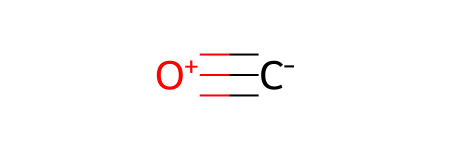

In [77]:
Chem.MolFromSmiles('[C-]#[O+]')

### Functions

Then, defining functions for extracting useful information

In [203]:
import sqlite3
import os
import dask.delayed as delayed
import dask.dataframe as dd
import dask.array as da
import dask.bag as db
import numpy as np
import pandas as pd


def info(molfile):
        mol=Chem.MolFromMolFile(molfile)
        if mol:
            Chem.SanitizeMol(mol)
            mol.UpdatePropertyCache(strict=False)
            smils=Chem.MolToSmiles(mol)
            return mol,smils
        else:
            return molfile

def basic(ID,folder):
    if str.isdecimal(ID):
        molfileaddress=folder+os.sep+ID
        try:
            res=info(molfileaddress)
        except Exception as e:
            error=e
            compaddrs={'SubstanceID':int(ID),'MolFileAddress':molfileaddress,'Error':error}
        else:
            if type(res)==tuple:
                smiles=res[1]
                compaddrs={'SubstanceID':int(ID),'MolFileAddress':molfileaddress,'Smiles':smiles}
            else:
                error='Valence error'
                compaddrs={'SubstanceID':int(ID),'MolFileAddress':molfileaddress,'Error':error}
    else:
        compaddrs={}
    return compaddrs

def basicgroup(molfilelist,folder):
    return [basic(ID,folder) for ID in molfilelist]

def substancedblist(folderName,partitions):
    dem=os.listdir(folderName)
    b=db.from_sequence(dem,npartitions=partitions)
    dflist=b.map_partitions(basicgroup,folderName).compute()
    return dflist

### Testing

This section tests some functions on files in ONE folder.

In [325]:
basic(os.listdir(folderNames[0])[0],folderNames[0])

{'SubstanceID': 6890270,
 'MolFileAddress': '/home/projects/graph/data/batch_6500000/6890270',
 'Smiles': 'CC(C)(C)[C@@H]1CC[C@@](C)(F)[C@H](Br)C1'}

In [342]:
testlist=os.listdir(folderNames[0])[:40]

testoutput=basicgroup(folderNames[0],testlist)

testoutput

RDKit ERROR: [09:06:59] Explicit valence for atom # 15 O, 3, is greater than permitted
RDKit ERROR: [09:06:59] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [09:06:59] Explicit valence for atom # 13 N, 4, is greater than permitted


[{'SubstanceID': 6890270,
  'MolFileAddress': '/home/projects/graph/data/batch_6500000/6890270',
  'Smiles': 'CC(C)(C)[C@@H]1CC[C@@](C)(F)[C@H](Br)C1'},
 {'SubstanceID': 27615522,
  'MolFileAddress': '/home/projects/graph/data/batch_6500000/27615522',
  'Smiles': 'Cc1cc(-c2nc3cc(F)ccc3c3cc4c(cc23)OCO4)ccc1F'},
 {'SubstanceID': 29164535,
  'MolFileAddress': '/home/projects/graph/data/batch_6500000/29164535',
  'Smiles': '[Gd+3].[Na+].[O-]B([O-])[O-].[Tb+3]'},
 {'SubstanceID': 11230426,
  'MolFileAddress': '/home/projects/graph/data/batch_6500000/11230426',
  'Smiles': 'Nc1cc(F)c(N2CC(F)C2)c(F)c1'},
 {'SubstanceID': 9019791,
  'MolFileAddress': '/home/projects/graph/data/batch_6500000/9019791',
  'Smiles': 'CCCCOc1ccc(-c2nc(-c3ccc(Cl)cc3)[nH]c2-c2ccncc2)c(OCCCC)c1'},
 {'SubstanceID': 4584084,
  'MolFileAddress': '/home/projects/graph/data/batch_6500000/4584084',
  'Smiles': 'CC(C)(C)OC(=O)C=C1C[N+]([O-])=C(c2ccccc2F)c2cc(Cl)ccc2N1'},
 {'SubstanceID': 918811,
  'MolFileAddress': '/home/pr

In [296]:
testdf=pd.DataFrame(testoutput)

In [297]:
testdf.set_index('SubstanceID',inplace=True)

In [298]:
testdf.loc[6890270,'MolFileAddress']

'/home/projects/graph/data/batch_6500000/6890270'

In [299]:
testdf.info()
testdf.to_parquet('/home/aa2133/Impurity-Project/Reaxys_Data/Substance_DB')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 6890270 to 9984310
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   MolFileAddress  40 non-null     object
 1   Smiles          37 non-null     object
 2   Error           3 non-null      object
dtypes: object(3)
memory usage: 2.5+ KB


In [300]:
writepickle(testdf,'/home/aa2133/Impurity-Project/Reaxys_Data/Substance_DB2')

In [301]:
testdf

,MolFileAddress,Smiles,Error
SubstanceID,,,
6890270,/home/projects/graph/data/batch_6500000/6890270,CC(C)(C)[C@@H]1CC[C@@](C)(F)[C@H](Br)C1,NaN
27615522,/home/projects/graph/data/batch_6500000/27615522,Cc1cc(-c2nc3cc(F)ccc3c3cc4c(cc23)OCO4)ccc1F,NaN
29164535,/home/projects/graph/data/batch_6500000/29164535,[Gd+3].[Na+].[O-]B([O-])[O-].[Tb+3],NaN
11230426,/home/projects/graph/data/batch_6500000/11230426,Nc1cc(F)c(N2CC(F)C2)c(F)c1,NaN
9019791,/home/projects/graph/data/batch_6500000/9019791,CCCCOc1ccc(-c2nc(-c3ccc(Cl)cc3)[nH]c2-c2ccncc2...,NaN
4584084,/home/projects/graph/data/batch_6500000/4584084,CC(C)(C)OC(=O)C=C1C[N+]([O-])=C(c2ccccc2F)c2cc...,NaN
918811,/home/projects/graph/data/batch_6500000/918811,Cc1cc([N+](=O)[O-])cc([N+](=O)[O-])c1NN,NaN
11185773,/home/projects/graph/data/batch_6500000/11185773,Cc1ccccc1CCCCCCC(=O)c1ncc(-c2ccccn2)o1,NaN
6156831,/home/projects/graph/data/batch_6500000/6156831,CCOC(=O)c1c(-c2cccc([N+](=O)[O-])c2)cc(-c2cccc...,NaN


It appears that pickle is faster than fastparquet for reading. However, fastparquet is better at storing dataframes amenable for parallel computation.

In [256]:
gg=openpickle('/home/aa2133/Impurity-Project/Reaxys_Data/Substance_DB2.pickle')

In [258]:
ff=pd.read_parquet('/home/aa2133/Impurity-Project/Reaxys_Data/Substance_DB')

### Parallelizing

This section contains the parallelization workflow, comparing it to sequential for a subset of the data

In [373]:
dem=os.listdir(folderNames[0])

In [374]:
results2=[basic(molfile,folderNames[0]) for molfile in dem]
results2

RDKit ERROR: [10:15:23] Explicit valence for atom # 15 O, 3, is greater than permitted
RDKit ERROR: [10:15:23] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:23] Explicit valence for atom # 13 N, 4, is greater than permitted
RDKit ERROR: [10:15:23] Explicit valence for atom # 2 C, 6, is greater than permitted
RDKit ERROR: [10:15:23] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [10:15:23] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [10:15:23] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:23] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'Pol' not found
RDKit ERROR: Violation occurred on line 91 in file /home/conda/feedstock_root/build_artifacts/rdkit_1603468912137/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [10:15:23] Explicit valence 

RDKit ERROR: [10:15:24] Explicit valence for atom # 0 B, 4, is greater than permitted
RDKit ERROR: [10:15:24] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:24] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [10:15:24] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [10:15:24] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:24] Explicit valence for atom # 5 C, 6, is greater than permitted
RDKit ERROR: [10:15:24] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:24] Explicit valence for atom # 13 O, 3, is greater than permitted
RDKit ERROR: [10:15:24] Explicit valence for atom # 15 O, 3, is greater than permitted
RDKit ERROR: [10:15:24] Explicit valence for atom # 3 Sn, 5, is greater than permitted
RDKit ERROR: [10:15:24] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:24] Explicit valence for atom #

RDKit ERROR: [10:15:25] Explicit valence for atom # 0 Sn, 8, is greater than permitted
RDKit ERROR: [10:15:25] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:25] Explicit valence for atom # 9 O, 3, is greater than permitted
RDKit ERROR: [10:15:25] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:25] Explicit valence for atom # 0 B, 4, is greater than permitted
RDKit ERROR: [10:15:25] Explicit valence for atom # 3 N, 7, is greater than permitted
RDKit ERROR: [10:15:25] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:25] Explicit valence for atom # 11 O, 3, is greater than permitted
RDKit ERROR: [10:15:25] Explicit valence for atom # 0 B, 5, is greater than permitted
RDKit ERROR: [10:15:25] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [10:15:25] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:25] Explicit valence for atom # 

RDKit ERROR: [10:15:26] Explicit valence for atom # 1 O, 4, is greater than permitted
RDKit ERROR: [10:15:26] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:15:26] Explicit valence for atom # 3 H, 2, is greater than permitted
RDKit ERROR: [10:15:26] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:26] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:26] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:26] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:26] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:26] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:26] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:26] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:26] Explicit valence for atom # 14

RDKit ERROR: [10:15:27] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [10:15:27] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'Pol' not found
RDKit ERROR: Violation occurred on line 91 in file /home/conda/feedstock_root/build_artifacts/rdkit_1603468912137/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [10:15:27] Explicit valence for atom # 16 N, 4, is greater than permitted
RDKit ERROR: [10:15:27] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [10:15:27] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [10:15:27] Explicit valence for atom # 12 O, 3, is greater than permitted
RDKit ERROR: [10:15:27] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'Pol' not found
RDKit ERROR: Violation occurred on line 91 in file /home/conda/feedstock_root/bui

RDKit ERROR: [10:15:28] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [10:15:28] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [10:15:28] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:28] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [10:15:28] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:28] Explicit valence for atom # 0 B, 7, is greater than permitted
RDKit ERROR: [10:15:28] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:28] Explicit valence for atom # 0 B, 4, is greater than permitted
RDKit ERROR: [10:15:28] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:28] Explicit valence for atom # 1 O, 4, is greater than permitted
RDKit ERROR: [10:15:28] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:28] Explicit valence for atom # 1 

RDKit ERROR: [10:15:29] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [10:15:29] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [10:15:29] Explicit valence for atom # 3 C, 6, is greater than permitted
RDKit ERROR: [10:15:29] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:29] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:29] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:29] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:29] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:29] Explicit valence for atom # 0 C, 6, is greater than permitted
RDKit ERROR: [10:15:29] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:29] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [10:15:29] Explicit valence for atom # 12

RDKit ERROR: [10:15:30] Explicit valence for atom # 0 Ba, 8, is greater than permitted
RDKit ERROR: [10:15:30] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:30] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:15:30] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'Pol' not found
RDKit ERROR: Violation occurred on line 91 in file /home/conda/feedstock_root/build_artifacts/rdkit_1603468912137/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [10:15:30] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:30] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [10:15:30] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:15:30] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:30] Explicit valence f

RDKit ERROR: [10:15:31] Explicit valence for atom # 0 B, 4, is greater than permitted
RDKit ERROR: [10:15:31] Explicit valence for atom # 26 N, 4, is greater than permitted
RDKit ERROR: [10:15:31] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:31] Explicit valence for atom # 9 O, 3, is greater than permitted
RDKit ERROR: [10:15:31] Explicit valence for atom # 16 N, 4, is greater than permitted
RDKit ERROR: [10:15:31] Explicit valence for atom # 0 B, 7, is greater than permitted
RDKit ERROR: [10:15:31] Explicit valence for atom # 2 C, 6, is greater than permitted
RDKit ERROR: [10:15:31] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [10:15:31] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:31] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [10:15:31] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [10:15:31] Explicit valence for atom #

RDKit ERROR: [10:15:32] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [10:15:32] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:32] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:32] Explicit valence for atom # 0 Li, 5, is greater than permitted
RDKit ERROR: [10:15:32] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'Pol' not found
RDKit ERROR: Violation occurred on line 91 in file /home/conda/feedstock_root/build_artifacts/rdkit_1603468912137/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [10:15:32] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [10:15:32] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:32] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:32] Explicit valence f

RDKit ERROR: [10:15:33] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:33] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:33] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [10:15:33] Explicit valence for atom # 0 B, 4, is greater than permitted
RDKit ERROR: [10:15:33] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:33] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:33] Explicit valence for atom # 0 Al, 7, is greater than permitted
RDKit ERROR: [10:15:33] Explicit valence for atom # 14 O, 3, is greater than permitted
RDKit ERROR: [10:15:33] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [10:15:33] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [10:15:33] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:33] Explicit valence for atom # 

RDKit ERROR: [10:15:34] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:15:34] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:34] Explicit valence for atom # 0 O, 5, is greater than permitted
RDKit ERROR: [10:15:34] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:34] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:34] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:34] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:34] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:34] Explicit valence for atom # 0 B, 7, is greater than permitted
RDKit ERROR: [10:15:34] Explicit valence for atom # 0 Sn, 8, is greater than permitted
RDKit ERROR: [10:15:34] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:34] Explicit valence for atom # 2

RDKit ERROR: [10:15:35] Explicit valence for atom # 14 O, 3, is greater than permitted
RDKit ERROR: [10:15:35] Explicit valence for atom # 1 N, 5, is greater than permitted
RDKit ERROR: [10:15:35] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:35] Explicit valence for atom # 9 O, 3, is greater than permitted
RDKit ERROR: [10:15:35] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:35] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [10:15:35] Explicit valence for atom # 0 B, 4, is greater than permitted
RDKit ERROR: [10:15:35] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [10:15:35] Explicit valence for atom # 4 C, 10, is greater than permitted
RDKit ERROR: [10:15:35] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:35] Explicit valence for atom # 0 B, 7, is greater than permitted
RDKit ERROR: [10:15:35] Explicit valence for atom # 

RDKit ERROR: [10:15:36] Explicit valence for atom # 0 B, 4, is greater than permitted
RDKit ERROR: [10:15:36] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:36] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:36] Explicit valence for atom # 9 O, 3, is greater than permitted
RDKit ERROR: [10:15:36] Explicit valence for atom # 5 B, 6, is greater than permitted
RDKit ERROR: [10:15:36] Explicit valence for atom # 16 C, 5, is greater than permitted
RDKit ERROR: [10:15:36] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'Pol' not found
RDKit ERROR: Violation occurred on line 91 in file /home/conda/feedstock_root/build_artifacts/rdkit_1603468912137/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [10:15:36] Explicit valence for atom # 0 C, 6, is greater than permitted
RDKit ERROR: [10:15:36] Explicit valence f

RDKit ERROR: [10:15:37] Explicit valence for atom # 0 N, 5, is greater than permitted
RDKit ERROR: [10:15:37] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:37] Explicit valence for atom # 37 O, 3, is greater than permitted
RDKit ERROR: [10:15:37] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:37] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:37] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [10:15:37] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:37] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:37] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:15:37] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [10:15:37] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [10:15:37] Explicit valence for atom # 3

RDKit ERROR: [10:15:38] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:38] Explicit valence for atom # 4 N, 5, is greater than permitted
RDKit ERROR: [10:15:38] Explicit valence for atom # 0 O, 6, is greater than permitted
RDKit ERROR: [10:15:38] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [10:15:38] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:38] Explicit valence for atom # 0 B, 4, is greater than permitted
RDKit ERROR: [10:15:38] Explicit valence for atom # 8 O, 3, is greater than permitted
RDKit ERROR: [10:15:38] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:15:38] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'Pol' not found
RDKit ERROR: Violation occurred on line 91 in file /home/conda/feedstock_root/build_artifacts/rdkit_1603468912137/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression:

RDKit ERROR: [10:15:40] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [10:15:40] Explicit valence for atom # 1 B, 6, is greater than permitted
RDKit ERROR: [10:15:40] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:40] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:40] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:40] Explicit valence for atom # 0 O, 5, is greater than permitted
RDKit ERROR: [10:15:40] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:40] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [10:15:40] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:40] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:40] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [10:15:40] Explicit valence for atom # 1 

RDKit ERROR: [10:15:41] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:41] Explicit valence for atom # 0 B, 4, is greater than permitted
RDKit ERROR: [10:15:41] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:41] Explicit valence for atom # 12 O, 3, is greater than permitted
RDKit ERROR: [10:15:41] Explicit valence for atom # 10 O, 6, is greater than permitted
RDKit ERROR: [10:15:41] Explicit valence for atom # 26 C, 5, is greater than permitted
RDKit ERROR: [10:15:41] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:41] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:41] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:15:41] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:41] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'Pol' not found
RDKit

RDKit ERROR: [10:15:42] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [10:15:42] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:42] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:42] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:42] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [10:15:42] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:42] Explicit valence for atom # 1 N, 5, is greater than permitted
RDKit ERROR: [10:15:42] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [10:15:42] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:15:42] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:42] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:42] Explicit valence for atom # 13

RDKit ERROR: [10:15:43] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:43] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:43] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:43] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:43] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [10:15:43] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [10:15:43] Explicit valence for atom # 0 B, 4, is greater than permitted
RDKit ERROR: [10:15:43] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:43] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:43] Explicit valence for atom # 0 B, 4, is greater than permitted
RDKit ERROR: [10:15:43] Explicit valence for atom # 11 O, 4, is greater than permitted
RDKit ERROR: [10:15:43] Explicit valence for atom # 9

RDKit ERROR: [10:15:44] Explicit valence for atom # 0 B, 4, is greater than permitted
RDKit ERROR: [10:15:44] Explicit valence for atom # 0 B, 6, is greater than permitted
RDKit ERROR: [10:15:44] Explicit valence for atom # 0 B, 7, is greater than permitted
RDKit ERROR: [10:15:44] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:44] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:44] Explicit valence for atom # 14 N, 4, is greater than permitted
RDKit ERROR: [10:15:44] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:44] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [10:15:44] Explicit valence for atom # 0 H, 4, is greater than permitted
RDKit ERROR: [10:15:44] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [10:15:44] Explicit valence for atom # 20 Al, 7, is greater than permitted
RDKit ERROR: [10:15:44] Explicit valence for atom #

RDKit ERROR: [10:15:44] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:44] Explicit valence for atom # 0 B, 4, is greater than permitted
RDKit ERROR: [10:15:44] Explicit valence for atom # 0 B, 4, is greater than permitted
RDKit ERROR: [10:15:45] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [10:15:45] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:45] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [10:15:45] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'Pol' not found
RDKit ERROR: Violation occurred on line 91 in file /home/conda/feedstock_root/build_artifacts/rdkit_1603468912137/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [10:15:45] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:45] Explicit valence fo

RDKit ERROR: [10:15:45] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:45] Explicit valence for atom # 6 O, 3, is greater than permitted
RDKit ERROR: [10:15:45] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [10:15:45] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'Pol' not found
RDKit ERROR: Violation occurred on line 91 in file /home/conda/feedstock_root/build_artifacts/rdkit_1603468912137/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [10:15:45] Explicit valence for atom # 0 Ga, 9, is greater than permitted
RDKit ERROR: [10:15:45] Explicit valence for atom # 0 B, 4, is greater than permitted
RDKit ERROR: [10:15:45] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:46] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:46] Explicit valence f

RDKit ERROR: [10:15:47] Explicit valence for atom # 0 B, 4, is greater than permitted
RDKit ERROR: [10:15:47] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [10:15:47] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [10:15:47] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [10:15:47] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [10:15:47] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:47] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [10:15:47] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [10:15:47] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:47] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [10:15:47] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:47] Explicit valence for atom # 1

RDKit ERROR: [10:15:48] Explicit valence for atom # 6 Al, 7, is greater than permitted
RDKit ERROR: [10:15:48] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:48] Explicit valence for atom # 12 O, 3, is greater than permitted
RDKit ERROR: [10:15:48] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [10:15:48] Explicit valence for atom # 0 B, 6, is greater than permitted
RDKit ERROR: [10:15:48] Explicit valence for atom # 0 Tl, 6, is greater than permitted
RDKit ERROR: [10:15:48] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'Pol' not found
RDKit ERROR: Violation occurred on line 91 in file /home/conda/feedstock_root/build_artifacts/rdkit_1603468912137/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [10:15:48] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [10:15:48] Explicit valence

RDKit ERROR: [10:15:49] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'Pol' not found
RDKit ERROR: Violation occurred on line 91 in file /home/conda/feedstock_root/build_artifacts/rdkit_1603468912137/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [10:15:49] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [10:15:49] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:49] Explicit valence for atom # 0 B, 4, is greater than permitted
RDKit ERROR: [10:15:49] Explicit valence for atom # 0 B, 4, is greater than permitted
RDKit ERROR: [10:15:49] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:49] Explicit valence for atom # 29 O, 4, is greater than permitted
RDKit ERROR: [10:15:49] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [10:15:49] Explicit valence 

RDKit ERROR: [10:15:49] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [10:15:49] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:49] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:49] Explicit valence for atom # 0 B, 7, is greater than permitted
RDKit ERROR: [10:15:49] Explicit valence for atom # 0 O, 5, is greater than permitted
RDKit ERROR: [10:15:49] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:49] Explicit valence for atom # 0 B, 7, is greater than permitted
RDKit ERROR: [10:15:49] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:50] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [10:15:50] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [10:15:50] Explicit valence for atom # 0 B, 4, is greater than permitted
RDKit ERROR: [10:15:50] Explicit valence for atom # 1 

RDKit ERROR: [10:15:50] Explicit valence for atom # 3 O, 4, is greater than permitted
RDKit ERROR: [10:15:50] Explicit valence for atom # 32 C, 5, is greater than permitted
RDKit ERROR: [10:15:50] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [10:15:50] Explicit valence for atom # 10 N, 4, is greater than permitted
RDKit ERROR: [10:15:50] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:50] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:50] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:50] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:50] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [10:15:50] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:50] Explicit valence for atom # 0 B, 7, is greater than permitted
RDKit ERROR: [10:15:50] Explicit valence for atom # 

RDKit ERROR: [10:15:51] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'Pol' not found
RDKit ERROR: Violation occurred on line 91 in file /home/conda/feedstock_root/build_artifacts/rdkit_1603468912137/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [10:15:51] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:15:51] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:51] Explicit valence for atom # 0 B, 6, is greater than permitted
RDKit ERROR: [10:15:51] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:51] Explicit valence for atom # 0 B, 5, is greater than permitted
RDKit ERROR: [10:15:51] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:51] Explicit valence for atom # 4 O, 4, is greater than permitted
RDKit ERROR: [10:15:51] Explicit valence fo

RDKit ERROR: [10:15:52] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:52] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [10:15:52] Explicit valence for atom # 18 O, 4, is greater than permitted
RDKit ERROR: [10:15:52] Explicit valence for atom # 4 O, 6, is greater than permitted
RDKit ERROR: [10:15:52] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:52] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:52] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [10:15:52] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:53] Explicit valence for atom # 16 N, 4, is greater than permitted
RDKit ERROR: [10:15:53] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [10:15:53] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [10:15:53] Explicit valence for atom # 

RDKit ERROR: [10:15:53] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:53] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [10:15:53] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:53] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:53] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:53] Explicit valence for atom # 2 O, 5, is greater than permitted
RDKit ERROR: [10:15:53] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [10:15:53] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:53] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:53] Explicit valence for atom # 0 B, 4, is greater than permitted
RDKit ERROR: [10:15:53] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:53] Explicit valence for atom # 10

RDKit ERROR: [10:15:54] Explicit valence for atom # 8 O, 3, is greater than permitted
RDKit ERROR: [10:15:54] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:54] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:54] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:54] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:54] Explicit valence for atom # 0 B, 7, is greater than permitted
RDKit ERROR: [10:15:54] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:54] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:54] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:54] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:54] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:15:54] Explicit valence for atom # 4 

RDKit ERROR: [10:15:55] Explicit valence for atom # 15 N, 4, is greater than permitted
RDKit ERROR: [10:15:55] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:55] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:55] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:55] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [10:15:55] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:55] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'Pol' not found
RDKit ERROR: Violation occurred on line 91 in file /home/conda/feedstock_root/build_artifacts/rdkit_1603468912137/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [10:15:55] Explicit valence for atom # 1 B, 4, is greater than permitted
RDKit ERROR: [10:15:55] Explicit valence f

RDKit ERROR: [10:15:56] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [10:15:56] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:56] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [10:15:56] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'Pol' not found
RDKit ERROR: Violation occurred on line 91 in file /home/conda/feedstock_root/build_artifacts/rdkit_1603468912137/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [10:15:56] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:56] Explicit valence for atom # 0 B, 4, is greater than permitted
RDKit ERROR: [10:15:56] Explicit valence for atom # 69 F, 2, is greater than permitted
RDKit ERROR: [10:15:56] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [10:15:56] Explicit valence f

RDKit ERROR: [10:15:57] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:15:57] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'Pol' not found
RDKit ERROR: Violation occurred on line 91 in file /home/conda/feedstock_root/build_artifacts/rdkit_1603468912137/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [10:15:57] Explicit valence for atom # 0 Ga, 7, is greater than permitted
RDKit ERROR: [10:15:57] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:57] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:15:57] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:57] Explicit valence for atom # 1 B, 7, is greater than permitted
RDKit ERROR: [10:15:57] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [10:15:57] Explicit valence f

RDKit ERROR: [10:15:58] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:58] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:15:58] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:58] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:58] Explicit valence for atom # 39 Ga, 7, is greater than permitted
RDKit ERROR: [10:15:58] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:58] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:58] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:58] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [10:15:58] Explicit valence for atom # 1 N, 6, is greater than permitted
RDKit ERROR: [10:15:58] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:58] Explicit valence for atom # 

RDKit ERROR: [10:15:59] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:59] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [10:15:59] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:59] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:15:59] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:59] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:59] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:59] Explicit valence for atom # 192 F, 2, is greater than permitted
RDKit ERROR: [10:15:59] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:15:59] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:59] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:15:59] Explicit valence for atom # 

RDKit ERROR: [10:15:59] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [10:16:00] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:00] Explicit valence for atom # 3 B, 5, is greater than permitted
RDKit ERROR: [10:16:00] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:00] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [10:16:00] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:00] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [10:16:00] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:00] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:00] Explicit valence for atom # 4 O, 4, is greater than permitted
RDKit ERROR: [10:16:00] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:00] Explicit valence for atom # 1 

RDKit ERROR: [10:16:00] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:00] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:00] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:00] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [10:16:00] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:01] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:01] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:01] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:01] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:01] Explicit valence for atom # 5 Li, 5, is greater than permitted
RDKit ERROR: [10:16:01] Explicit valence for atom # 6 B, 6, is greater than permitted
RDKit ERROR: [10:16:01] Explicit valence for atom # 1

RDKit ERROR: [10:16:02] Explicit valence for atom # 0 Mg, 6, is greater than permitted
RDKit ERROR: [10:16:02] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [10:16:02] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [10:16:02] Explicit valence for atom # 15 O, 3, is greater than permitted
RDKit ERROR: [10:16:02] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:02] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:02] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [10:16:02] Explicit valence for atom # 8 O, 3, is greater than permitted
RDKit ERROR: [10:16:02] Explicit valence for atom # 0 B, 6, is greater than permitted
RDKit ERROR: [10:16:02] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:02] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:02] Explicit valence for atom # 

RDKit ERROR: [10:16:03] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:03] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:03] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [10:16:03] Explicit valence for atom # 15 C, 5, is greater than permitted
RDKit ERROR: [10:16:03] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [10:16:03] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'Pol' not found
RDKit ERROR: Violation occurred on line 91 in file /home/conda/feedstock_root/build_artifacts/rdkit_1603468912137/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [10:16:03] Explicit valence for atom # 18 O, 3, is greater than permitted
RDKit ERROR: [10:16:03] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:03] Explicit valence 

RDKit ERROR: [10:16:04] Explicit valence for atom # 10 O, 5, is greater than permitted
RDKit ERROR: [10:16:04] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [10:16:04] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [10:16:04] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:04] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:04] Explicit valence for atom # 9 O, 3, is greater than permitted
RDKit ERROR: [10:16:04] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [10:16:04] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:04] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [10:16:04] Explicit valence for atom # 0 Ca, 9, is greater than permitted
RDKit ERROR: [10:16:04] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:04] Explicit valence for atom #

RDKit ERROR: [10:16:05] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [10:16:05] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [10:16:05] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [10:16:05] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'Pol' not found
RDKit ERROR: Violation occurred on line 91 in file /home/conda/feedstock_root/build_artifacts/rdkit_1603468912137/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [10:16:05] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:05] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [10:16:05] Explicit valence for atom # 0 C, 6, is greater than permitted
RDKit ERROR: [10:16:05] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:05] Explicit valence fo

RDKit ERROR: [10:16:06] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:06] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:06] Explicit valence for atom # 14 O, 3, is greater than permitted
RDKit ERROR: [10:16:06] Explicit valence for atom # 4 C, 6, is greater than permitted
RDKit ERROR: [10:16:06] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:06] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:16:06] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:06] Explicit valence for atom # 5 O, 5, is greater than permitted
RDKit ERROR: [10:16:06] Explicit valence for atom # 0 B, 4, is greater than permitted
RDKit ERROR: [10:16:06] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:06] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [10:16:06] Explicit valence for atom # 2

RDKit ERROR: [10:16:07] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [10:16:07] Explicit valence for atom # 0 Al, 9, is greater than permitted
RDKit ERROR: [10:16:07] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:07] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:07] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:07] Explicit valence for atom # 8 O, 3, is greater than permitted
RDKit ERROR: [10:16:07] Explicit valence for atom # 15 O, 3, is greater than permitted
RDKit ERROR: [10:16:07] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:07] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [10:16:07] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:07] Explicit valence for atom # 6 O, 4, is greater than permitted
RDKit ERROR: [10:16:07] Explicit valence for atom #

RDKit ERROR: [10:16:08] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [10:16:08] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [10:16:08] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:08] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:08] Explicit valence for atom # 0 B, 7, is greater than permitted
RDKit ERROR: [10:16:08] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:08] Explicit valence for atom # 0 B, 4, is greater than permitted
RDKit ERROR: [10:16:08] Explicit valence for atom # 11 O, 4, is greater than permitted
RDKit ERROR: [10:16:08] Explicit valence for atom # 0 Ga, 7, is greater than permitted
RDKit ERROR: [10:16:08] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [10:16:08] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:08] 
RDKit ERROR: 
RDKit ERROR: 

RDKit ERROR: [10:16:09] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:09] Explicit valence for atom # 8 B, 6, is greater than permitted
RDKit ERROR: [10:16:09] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:09] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'Pol' not found
RDKit ERROR: Violation occurred on line 91 in file /home/conda/feedstock_root/build_artifacts/rdkit_1603468912137/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [10:16:09] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:09] Explicit valence for atom # 60 C, 5, is greater than permitted
RDKit ERROR: [10:16:09] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [10:16:09] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:09] Explicit valence f

RDKit ERROR: [10:16:10] Explicit valence for atom # 11 N, 4, is greater than permitted
RDKit ERROR: [10:16:10] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:10] Explicit valence for atom # 1 N, 6, is greater than permitted
RDKit ERROR: [10:16:10] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:16:10] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:10] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [10:16:10] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:10] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:10] Explicit valence for atom # 0 Al, 14, is greater than permitted
RDKit ERROR: [10:16:10] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:10] Explicit valence for atom # 0 B, 4, is greater than permitted
RDKit ERROR: [10:16:10] Explicit valence for atom #

RDKit ERROR: [10:16:10] Explicit valence for atom # 24 N, 4, is greater than permitted
RDKit ERROR: [10:16:10] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:10] Explicit valence for atom # 0 B, 4, is greater than permitted
RDKit ERROR: [10:16:10] Explicit valence for atom # 0 B, 7, is greater than permitted
RDKit ERROR: [10:16:10] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [10:16:10] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [10:16:11] Explicit valence for atom # 0 O, 4, is greater than permitted
RDKit ERROR: [10:16:11] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'Pol' not found
RDKit ERROR: Violation occurred on line 91 in file /home/conda/feedstock_root/build_artifacts/rdkit_1603468912137/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [10:16:11] Explicit valence f

RDKit ERROR: [10:16:11] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [10:16:11] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [10:16:11] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [10:16:11] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:11] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:11] Explicit valence for atom # 18 C, 5, is greater than permitted
RDKit ERROR: [10:16:11] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:11] Explicit valence for atom # 2 N, 5, is greater than permitted
RDKit ERROR: [10:16:11] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:16:11] Explicit valence for atom # 15 O, 3, is greater than permitted
RDKit ERROR: [10:16:11] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:11] Explicit valence for atom # 

RDKit ERROR: [10:16:12] Explicit valence for atom # 0 B, 4, is greater than permitted
RDKit ERROR: [10:16:12] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:12] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:16:12] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'Pol' not found
RDKit ERROR: Violation occurred on line 91 in file /home/conda/feedstock_root/build_artifacts/rdkit_1603468912137/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [10:16:12] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [10:16:12] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:12] Explicit valence for atom # 0 B, 4, is greater than permitted
RDKit ERROR: [10:16:12] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [10:16:12] Explicit valence fo

RDKit ERROR: [10:16:13] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:13] Explicit valence for atom # 12 O, 3, is greater than permitted
RDKit ERROR: [10:16:13] Explicit valence for atom # 8 O, 3, is greater than permitted
RDKit ERROR: [10:16:13] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [10:16:13] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:16:13] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:13] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'Pol' not found
RDKit ERROR: Violation occurred on line 91 in file /home/conda/feedstock_root/build_artifacts/rdkit_1603468912137/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [10:16:13] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [10:16:13] 
RDKit ERROR: 
RDK

RDKit ERROR: [10:16:14] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:16:14] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:14] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:14] Explicit valence for atom # 0 N, 5, is greater than permitted
RDKit ERROR: [10:16:14] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [10:16:14] Explicit valence for atom # 0 Al, 8, is greater than permitted
RDKit ERROR: [10:16:14] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:14] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:14] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:14] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:14] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'Pol' not found
RDKit E

RDKit ERROR: [10:16:15] Explicit valence for atom # 0 B, 4, is greater than permitted
RDKit ERROR: [10:16:15] Explicit valence for atom # 45 F, 2, is greater than permitted
RDKit ERROR: [10:16:15] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [10:16:15] Explicit valence for atom # 26 C, 5, is greater than permitted
RDKit ERROR: [10:16:15] Explicit valence for atom # 1 Li, 6, is greater than permitted
RDKit ERROR: [10:16:15] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [10:16:15] Explicit valence for atom # 19 N, 4, is greater than permitted
RDKit ERROR: [10:16:15] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:16:15] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:15] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:15] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:15] Explicit valence for atom 

RDKit ERROR: [10:16:16] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:16] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:16] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [10:16:16] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:16] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:16] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:16] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [10:16:16] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [10:16:16] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:16:16] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:16] Explicit valence for atom # 7 O, 3, is greater than permitted
RDKit ERROR: [10:16:16] Explicit valence for atom # 1 

RDKit ERROR: [10:16:17] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:17] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'Pol' not found
RDKit ERROR: Violation occurred on line 91 in file /home/conda/feedstock_root/build_artifacts/rdkit_1603468912137/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [10:16:17] Explicit valence for atom # 16 C, 5, is greater than permitted
RDKit ERROR: [10:16:17] Explicit valence for atom # 6 H, 2, is greater than permitted
RDKit ERROR: [10:16:17] Explicit valence for atom # 18 O, 3, is greater than permitted
RDKit ERROR: [10:16:17] Explicit valence for atom # 11 O, 3, is greater than permitted
RDKit ERROR: [10:16:17] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [10:16:17] Explicit valence for atom # 0 B, 7, is greater than permitted
RDKit ERROR: [10:16:17] Explicit valence

RDKit ERROR: [10:16:18] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [10:16:18] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [10:16:18] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:16:18] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [10:16:18] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:18] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:18] Explicit valence for atom # 20 N, 4, is greater than permitted
RDKit ERROR: [10:16:18] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:18] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:18] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:18] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:18] Explicit valence for atom # 1

RDKit ERROR: [10:16:19] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:19] Explicit valence for atom # 0 B, 4, is greater than permitted
RDKit ERROR: [10:16:19] Explicit valence for atom # 16 O, 3, is greater than permitted
RDKit ERROR: [10:16:19] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [10:16:19] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:16:19] Explicit valence for atom # 1 O, 4, is greater than permitted
RDKit ERROR: [10:16:19] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [10:16:19] Explicit valence for atom # 8 O, 3, is greater than permitted
RDKit ERROR: [10:16:19] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:19] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [10:16:19] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [10:16:19] Explicit valence for atom # 7

RDKit ERROR: [10:16:20] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:20] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:16:20] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:20] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:20] Explicit valence for atom # 4 In, 7, is greater than permitted
RDKit ERROR: [10:16:20] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:20] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:20] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:20] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [10:16:20] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [10:16:20] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:20] Explicit valence for atom # 1

RDKit ERROR: [10:16:20] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:20] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [10:16:20] Explicit valence for atom # 97 N, 4, is greater than permitted
RDKit ERROR: [10:16:20] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:20] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [10:16:20] Explicit valence for atom # 0 B, 4, is greater than permitted
RDKit ERROR: [10:16:21] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:21] Explicit valence for atom # 0 B, 7, is greater than permitted
RDKit ERROR: [10:16:21] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [10:16:21] Explicit valence for atom # 1 B, 5, is greater than permitted
RDKit ERROR: [10:16:21] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:21] Explicit valence for atom # 1

RDKit ERROR: [10:16:22] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:22] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:22] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:22] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:22] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:16:22] Explicit valence for atom # 1 Sn, 5, is greater than permitted
RDKit ERROR: [10:16:22] Explicit valence for atom # 0 Li, 5, is greater than permitted
RDKit ERROR: [10:16:22] Explicit valence for atom # 0 Li, 7, is greater than permitted
RDKit ERROR: [10:16:22] Explicit valence for atom # 0 B, 4, is greater than permitted
RDKit ERROR: [10:16:22] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:22] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'Pol' not found
RDKit

RDKit ERROR: [10:16:23] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:23] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:23] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [10:16:23] Explicit valence for atom # 0 B, 4, is greater than permitted
RDKit ERROR: [10:16:23] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:23] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:23] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [10:16:23] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:23] Explicit valence for atom # 6 F, 2, is greater than permitted
RDKit ERROR: [10:16:23] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [10:16:23] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:23] Explicit valence for atom # 1 

RDKit ERROR: [10:16:24] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [10:16:24] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:24] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [10:16:24] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [10:16:24] Explicit valence for atom # 0 B, 4, is greater than permitted
RDKit ERROR: [10:16:24] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:24] Explicit valence for atom # 30 B, 4, is greater than permitted
RDKit ERROR: [10:16:24] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:24] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [10:16:24] Explicit valence for atom # 11 N, 4, is greater than permitted
RDKit ERROR: [10:16:24] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:16:24] Explicit valence for atom # 

RDKit ERROR: [10:16:25] Explicit valence for atom # 0 B, 7, is greater than permitted
RDKit ERROR: [10:16:25] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [10:16:25] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:25] Explicit valence for atom # 20 O, 3, is greater than permitted
RDKit ERROR: [10:16:25] Explicit valence for atom # 1 O, 4, is greater than permitted
RDKit ERROR: [10:16:25] Explicit valence for atom # 1 O, 4, is greater than permitted
RDKit ERROR: [10:16:25] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:25] Explicit valence for atom # 29 N, 4, is greater than permitted
RDKit ERROR: [10:16:25] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:16:25] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [10:16:25] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:25] Explicit valence for atom # 

RDKit ERROR: [10:16:25] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:25] Explicit valence for atom # 2 C, 6, is greater than permitted
RDKit ERROR: [10:16:25] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:25] Explicit valence for atom # 0 C, 6, is greater than permitted
RDKit ERROR: [10:16:25] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:25] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:25] Explicit valence for atom # 14 O, 3, is greater than permitted
RDKit ERROR: [10:16:25] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:25] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:25] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:25] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:16:25] Explicit valence for atom # 5

RDKit ERROR: [10:16:26] Explicit valence for atom # 10 N, 4, is greater than permitted
RDKit ERROR: [10:16:26] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:26] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:16:26] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:26] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'Pol' not found
RDKit ERROR: Violation occurred on line 91 in file /home/conda/feedstock_root/build_artifacts/rdkit_1603468912137/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [10:16:26] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:16:26] Explicit valence for atom # 0 N, 5, is greater than permitted
RDKit ERROR: [10:16:26] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [10:16:26] Explicit valence f

RDKit ERROR: [10:16:27] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [10:16:27] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:27] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:27] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:27] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [10:16:27] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [10:16:27] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:27] Explicit valence for atom # 39 F, 2, is greater than permitted
RDKit ERROR: [10:16:27] Explicit valence for atom # 0 Sn, 6, is greater than permitted
RDKit ERROR: [10:16:27] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:27] Explicit valence for atom # 5 C, 6, is greater than permitted
RDKit ERROR: [10:16:27] Explicit valence for atom # 

RDKit ERROR: [10:16:28] Explicit valence for atom # 27 O, 3, is greater than permitted
RDKit ERROR: [10:16:28] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:16:28] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [10:16:28] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [10:16:28] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:28] Explicit valence for atom # 3 C, 6, is greater than permitted
RDKit ERROR: [10:16:28] Explicit valence for atom # 17 C greater than permitted
RDKit ERROR: [10:16:28] Explicit valence for atom # 3 C, 6, is greater than permitted
RDKit ERROR: [10:16:28] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:28] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [10:16:28] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [10:16:28] Explicit valence for atom # 1 N, 4,

RDKit ERROR: [10:16:29] Explicit valence for atom # 5 H, 3, is greater than permitted
RDKit ERROR: [10:16:30] Explicit valence for atom # 6 K, 7, is greater than permitted
RDKit ERROR: [10:16:30] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [10:16:30] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:30] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:30] Explicit valence for atom # 16 F, 2, is greater than permitted
RDKit ERROR: [10:16:30] Explicit valence for atom # 9 O, 3, is greater than permitted
RDKit ERROR: [10:16:30] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:30] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:30] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:30] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [10:16:30] Explicit valence for atom # 1

RDKit ERROR: [10:16:30] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [10:16:30] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:30] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:30] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [10:16:30] Explicit valence for atom # 0 B, 7, is greater than permitted
RDKit ERROR: [10:16:30] Explicit valence for atom # 3 C, 6, is greater than permitted
RDKit ERROR: [10:16:31] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [10:16:31] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'Pol' not found
RDKit ERROR: Violation occurred on line 91 in file /home/conda/feedstock_root/build_artifacts/rdkit_1603468912137/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [10:16:31] Explicit valence fo

RDKit ERROR: [10:16:31] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:31] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [10:16:31] Explicit valence for atom # 0 B, 4, is greater than permitted
RDKit ERROR: [10:16:31] Explicit valence for atom # 12 O, 3, is greater than permitted
RDKit ERROR: [10:16:31] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:31] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:16:31] Explicit valence for atom # 6 O, 4, is greater than permitted
RDKit ERROR: [10:16:31] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:31] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:32] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:16:32] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:32] Explicit valence for atom # 4

RDKit ERROR: [10:16:32] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [10:16:32] Explicit valence for atom # 21 O, 3, is greater than permitted
RDKit ERROR: [10:16:32] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:32] Explicit valence for atom # 0 Ca, 10, is greater than permitted
RDKit ERROR: [10:16:32] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:32] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:32] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [10:16:32] Explicit valence for atom # 0 B, 7, is greater than permitted
RDKit ERROR: [10:16:32] Explicit valence for atom # 2 C, 6, is greater than permitted
RDKit ERROR: [10:16:32] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:32] Explicit valence for atom # 10 O, 4, is greater than permitted
RDKit ERROR: [10:16:33] Explicit valence for atom 

RDKit ERROR: [10:16:33] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [10:16:33] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:33] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:33] Explicit valence for atom # 16 C, 5, is greater than permitted
RDKit ERROR: [10:16:33] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:33] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:33] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [10:16:33] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:33] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'Pol' not found
RDKit ERROR: Violation occurred on line 91 in file /home/conda/feedstock_root/build_artifacts/rdkit_1603468912137/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression

RDKit ERROR: [10:16:34] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:34] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:34] Explicit valence for atom # 0 B, 4, is greater than permitted
RDKit ERROR: [10:16:34] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:34] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:34] Explicit valence for atom # 4 B, 4, is greater than permitted
RDKit ERROR: [10:16:34] Explicit valence for atom # 0 B, 4, is greater than permitted
RDKit ERROR: [10:16:34] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:34] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:34] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:34] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [10:16:34] Explicit valence for atom # 1 

RDKit ERROR: [10:16:35] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:35] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:35] Explicit valence for atom # 0 Al, 8, is greater than permitted
RDKit ERROR: [10:16:35] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:35] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [10:16:35] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:35] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:16:35] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:35] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [10:16:35] Explicit valence for atom # 16 O, 3, is greater than permitted
RDKit ERROR: [10:16:35] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:35] Explicit valence for atom # 

RDKit ERROR: [10:16:36] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:16:36] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:36] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [10:16:36] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:36] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:36] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:36] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:16:36] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:36] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:36] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [10:16:36] Explicit valence for atom # 2 B, 4, is greater than permitted
RDKit ERROR: [10:16:36] Explicit valence for atom # 2 

RDKit ERROR: [10:16:37] Explicit valence for atom # 14 O, 3, is greater than permitted
RDKit ERROR: [10:16:37] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:37] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [10:16:37] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:37] Explicit valence for atom # 2 O, 4, is greater than permitted
RDKit ERROR: [10:16:37] Explicit valence for atom # 1 F, 3, is greater than permitted
RDKit ERROR: [10:16:37] Explicit valence for atom # 0 Sn, 5, is greater than permitted
RDKit ERROR: [10:16:37] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'Pol' not found
RDKit ERROR: Violation occurred on line 91 in file /home/conda/feedstock_root/build_artifacts/rdkit_1603468912137/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [10:16:37] Explicit valence 

RDKit ERROR: [10:16:38] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [10:16:38] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:38] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:38] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:38] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [10:16:38] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:38] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'Pol' not found
RDKit ERROR: Violation occurred on line 91 in file /home/conda/feedstock_root/build_artifacts/rdkit_1603468912137/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [10:16:38] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:38] Explicit valence fo

RDKit ERROR: [10:16:39] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [10:16:39] Explicit valence for atom # 5 O, 5, is greater than permitted
RDKit ERROR: [10:16:39] Explicit valence for atom # 4 C, 6, is greater than permitted
RDKit ERROR: [10:16:39] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:39] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:39] Explicit valence for atom # 0 C, 6, is greater than permitted
RDKit ERROR: [10:16:39] Explicit valence for atom # 0 O, 6, is greater than permitted
RDKit ERROR: [10:16:39] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [10:16:39] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:39] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:39] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [10:16:39] Explicit valence for atom # 1

RDKit ERROR: [10:16:40] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'Pol' not found
RDKit ERROR: Violation occurred on line 91 in file /home/conda/feedstock_root/build_artifacts/rdkit_1603468912137/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [10:16:40] Explicit valence for atom # 0 B, 4, is greater than permitted
RDKit ERROR: [10:16:40] Explicit valence for atom # 17 C, 5, is greater than permitted
RDKit ERROR: [10:16:40] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:40] Explicit valence for atom # 61 F, 2, is greater than permitted
RDKit ERROR: [10:16:40] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:40] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'Pol' not found
RDKit ERROR: Violation occurred on line 91 in file /home/conda/feedstock_root/bui

RDKit ERROR: [10:16:42] Explicit valence for atom # 16 O, 3, is greater than permitted
RDKit ERROR: [10:16:42] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:42] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:42] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:42] Explicit valence for atom # 15 O, 3, is greater than permitted
RDKit ERROR: [10:16:42] Explicit valence for atom # 0 B, 7, is greater than permitted
RDKit ERROR: [10:16:42] Explicit valence for atom # 8 C, 5, is greater than permitted
RDKit ERROR: [10:16:42] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:16:42] Explicit valence for atom # 9 B, 4, is greater than permitted
RDKit ERROR: [10:16:42] Explicit valence for atom # 6 O, 4, is greater than permitted
RDKit ERROR: [10:16:42] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [10:16:42] Explicit valence for atom # 

RDKit ERROR: [10:16:42] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:42] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:42] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:16:42] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [10:16:43] Explicit valence for atom # 22 N, 4, is greater than permitted
RDKit ERROR: [10:16:43] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:43] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:43] Explicit valence for atom # 3 C, 6, is greater than permitted
RDKit ERROR: [10:16:43] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:43] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:43] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:43] Explicit valence for atom # 1

RDKit ERROR: [10:16:43] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:43] Explicit valence for atom # 6 O, 3, is greater than permitted
RDKit ERROR: [10:16:43] Explicit valence for atom # 0 B, 4, is greater than permitted
RDKit ERROR: [10:16:43] Explicit valence for atom # 41 O, 3, is greater than permitted
RDKit ERROR: [10:16:43] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:43] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [10:16:44] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [10:16:44] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:44] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:44] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:44] Explicit valence for atom # 1 O, 4, is greater than permitted
RDKit ERROR: [10:16:44] Explicit valence for atom # 2

RDKit ERROR: [10:16:44] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'Pol' not found
RDKit ERROR: Violation occurred on line 91 in file /home/conda/feedstock_root/build_artifacts/rdkit_1603468912137/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [10:16:44] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:44] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:16:44] Explicit valence for atom # 19 N, 4, is greater than permitted
RDKit ERROR: [10:16:44] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:16:44] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [10:16:45] Explicit valence for atom # 0 C, 6, is greater than permitted
RDKit ERROR: [10:16:45] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:16:45] Explicit valence f

[{'SubstanceID': 6890270,
  'MolFileAddress': '/home/projects/graph/data/batch_6500000/6890270',
  'Smiles': 'CC(C)(C)[C@@H]1CC[C@@](C)(F)[C@H](Br)C1'},
 {'SubstanceID': 27615522,
  'MolFileAddress': '/home/projects/graph/data/batch_6500000/27615522',
  'Smiles': 'Cc1cc(-c2nc3cc(F)ccc3c3cc4c(cc23)OCO4)ccc1F'},
 {'SubstanceID': 29164535,
  'MolFileAddress': '/home/projects/graph/data/batch_6500000/29164535',
  'Smiles': '[Gd+3].[Na+].[O-]B([O-])[O-].[Tb+3]'},
 {'SubstanceID': 11230426,
  'MolFileAddress': '/home/projects/graph/data/batch_6500000/11230426',
  'Smiles': 'Nc1cc(F)c(N2CC(F)C2)c(F)c1'},
 {'SubstanceID': 9019791,
  'MolFileAddress': '/home/projects/graph/data/batch_6500000/9019791',
  'Smiles': 'CCCCOc1ccc(-c2nc(-c3ccc(Cl)cc3)[nH]c2-c2ccncc2)c(OCCCC)c1'},
 {'SubstanceID': 4584084,
  'MolFileAddress': '/home/projects/graph/data/batch_6500000/4584084',
  'Smiles': 'CC(C)(C)OC(=O)C=C1C[N+]([O-])=C(c2ccccc2F)c2cc(Cl)ccc2N1'},
 {'SubstanceID': 918811,
  'MolFileAddress': '/home/pr

How about dask.bag or dask.dataframe? Using dask.bag to split the data into 8 partitions, the computations finishes in 14.3 seconds, almost 38 times faster than sequential. client.map(), whilst good, has an overhead of 1 ms for each task which is apparently why it's slower (https://docs.dask.org/en/latest/futures.html). Note that this is after python caching. Before caching, sequential code took almost 9.5 minutes.

In [49]:
import dask.bag as db
import dask.dataframe as dd
import dask.array as da

dem=os.listdir(folderNames[0])

In [328]:
type(dem[0])

str

In [50]:
b=db.from_sequence(dem,npartitions=16)

The below does an elementwise mapping

In [51]:
dflist=b.map(basic,folderNames[0]).compute()

In [52]:
dflist

[{'SubstanceID': 6890270,
  'MolFileAddress': '/home/projects/graph/data/batch_6500000/6890270',
  'Smiles': 'CC(C)(C)[C@@H]1CC[C@@](C)(F)[C@H](Br)C1'},
 {'SubstanceID': 27615522,
  'MolFileAddress': '/home/projects/graph/data/batch_6500000/27615522',
  'Smiles': 'Cc1cc(-c2nc3cc(F)ccc3c3cc4c(cc23)OCO4)ccc1F'},
 {'SubstanceID': 29164535,
  'MolFileAddress': '/home/projects/graph/data/batch_6500000/29164535',
  'Smiles': '[Gd+3].[Na+].[O-]B([O-])[O-].[Tb+3]'},
 {'SubstanceID': 11230426,
  'MolFileAddress': '/home/projects/graph/data/batch_6500000/11230426',
  'Smiles': 'Nc1cc(F)c(N2CC(F)C2)c(F)c1'},
 {'SubstanceID': 9019791,
  'MolFileAddress': '/home/projects/graph/data/batch_6500000/9019791',
  'Smiles': 'CCCCOc1ccc(-c2nc(-c3ccc(Cl)cc3)[nH]c2-c2ccncc2)c(OCCCC)c1'},
 {'SubstanceID': 4584084,
  'MolFileAddress': '/home/projects/graph/data/batch_6500000/4584084',
  'Smiles': 'CC(C)(C)OC(=O)C=C1C[N+]([O-])=C(c2ccccc2F)c2cc(Cl)ccc2N1'},
 {'SubstanceID': 918811,
  'MolFileAddress': '/home/pr

Mapping the function to partitions instead of each element is slightly faster, taking only 6 seconds

In [53]:
dflist3=b.map_partitions(basicgroup,folderNames[0]).compute()

In [54]:
dflist3
dflist3==dflist

[{'SubstanceID': 6890270,
  'MolFileAddress': '/home/projects/graph/data/batch_6500000/6890270',
  'Smiles': 'CC(C)(C)[C@@H]1CC[C@@](C)(F)[C@H](Br)C1'},
 {'SubstanceID': 27615522,
  'MolFileAddress': '/home/projects/graph/data/batch_6500000/27615522',
  'Smiles': 'Cc1cc(-c2nc3cc(F)ccc3c3cc4c(cc23)OCO4)ccc1F'},
 {'SubstanceID': 29164535,
  'MolFileAddress': '/home/projects/graph/data/batch_6500000/29164535',
  'Smiles': '[Gd+3].[Na+].[O-]B([O-])[O-].[Tb+3]'},
 {'SubstanceID': 11230426,
  'MolFileAddress': '/home/projects/graph/data/batch_6500000/11230426',
  'Smiles': 'Nc1cc(F)c(N2CC(F)C2)c(F)c1'},
 {'SubstanceID': 9019791,
  'MolFileAddress': '/home/projects/graph/data/batch_6500000/9019791',
  'Smiles': 'CCCCOc1ccc(-c2nc(-c3ccc(Cl)cc3)[nH]c2-c2ccncc2)c(OCCCC)c1'},
 {'SubstanceID': 4584084,
  'MolFileAddress': '/home/projects/graph/data/batch_6500000/4584084',
  'Smiles': 'CC(C)(C)OC(=O)C=C1C[N+]([O-])=C(c2ccccc2F)c2cc(Cl)ccc2N1'},
 {'SubstanceID': 918811,
  'MolFileAddress': '/home/pr

True

The output is a list of dictionaries containing relevant column information for each processable molfile. This can be processed into a dataframe shown below.

In [56]:
demodb=pd.DataFrame(dflist3)

In [63]:
demodb

,SubstanceID,MolFileAddress,Smiles,Error
0,6890270.0,/home/projects/graph/data/batch_6500000/6890270,CC(C)(C)[C@@H]1CC[C@@](C)(F)[C@H](Br)C1,NaN
1,27615522.0,/home/projects/graph/data/batch_6500000/27615522,Cc1cc(-c2nc3cc(F)ccc3c3cc4c(cc23)OCO4)ccc1F,NaN
2,29164535.0,/home/projects/graph/data/batch_6500000/29164535,[Gd+3].[Na+].[O-]B([O-])[O-].[Tb+3],NaN
3,11230426.0,/home/projects/graph/data/batch_6500000/11230426,Nc1cc(F)c(N2CC(F)C2)c(F)c1,NaN
4,9019791.0,/home/projects/graph/data/batch_6500000/9019791,CCCCOc1ccc(-c2nc(-c3ccc(Cl)cc3)[nH]c2-c2ccncc2...,NaN
...,...,...,...,...
98389,32205608.0,/home/projects/graph/data/batch_6500000/32205608,C[C@@H]1C(=O)[C@@](C)(NC(=O)c2ccccc2)C(=O)N1C(...,NaN
98390,22856371.0,/home/projects/graph/data/batch_6500000/22856371,c1ccc2c(c1)nc(NC1CCCCC1)c1c3ccccc3[nH]c21,NaN
98391,11248101.0,/home/projects/graph/data/batch_6500000/11248101,CCCN1CCOC(c2cccc(SC)c2)C1,NaN
98392,30724739.0,/home/projects/graph/data/batch_6500000/30724739,C=C(C1CCCCC1)[Si](C)(C)Cc1ccccc1,NaN


In [72]:
demodb.info()
demodb.convert_dtypes().dtypes
demodb["SubstanceID"].isnull().values.any()
demodb["SubstanceID"].isnull().sum()
demodb[demodb["SubstanceID"].isnull()]
demodb.iloc[46675:46678]
# demodb=demodb.astype({"SubstanceID":int,"MolFileAddress":str,"Smiles":str,"Error":str})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98394 entries, 0 to 98393
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SubstanceID     98393 non-null  float64
 1   MolFileAddress  98393 non-null  object 
 2   Smiles          90390 non-null  object 
 3   Error           8003 non-null   object 
dtypes: float64(1), object(3)
memory usage: 3.0+ MB


SubstanceID        Int64
MolFileAddress    string
Smiles            string
Error             string
dtype: object

True

1

,SubstanceID,MolFileAddress,Smiles,Error
46676,NaN,NaN,NaN,NaN


,SubstanceID,MolFileAddress,Smiles,Error
46675,6506367.0,/home/projects/graph/data/batch_6500000/6506367,CCC/C=C(\O[Si](C)(C)C)C1(C)CC=C(C)CC1,NaN
46676,NaN,NaN,NaN,NaN
46677,7496573.0,/home/projects/graph/data/batch_6500000/7496573,Cc1ccc(C/C(=N\c2ccc([N+](=O)[O-])cc2C=O)N2CCOC...,NaN


In [126]:
demodb.loc[demodb["SubstanceID"]==31704591]
demodb=demodb.dropna(how='all')

,SubstanceID,MolFileAddress,Smiles,Error
92250,31704591.0,/home/projects/graph/data/batch_6500000/31704591,CCCC1CCCCN1C(=O)c1cccc(-c2cccc(-n3ncc(C(=O)O)c...,NaN


We can change the datatype of the substance id column, dropping rows where all values are NaN

In [91]:
demodb.astype({'SubstanceID':int})

,SubstanceID,MolFileAddress,Smiles,Error
0,6890270,/home/projects/graph/data/batch_6500000/6890270,CC(C)(C)[C@@H]1CC[C@@](C)(F)[C@H](Br)C1,NaN
1,27615522,/home/projects/graph/data/batch_6500000/27615522,Cc1cc(-c2nc3cc(F)ccc3c3cc4c(cc23)OCO4)ccc1F,NaN
2,29164535,/home/projects/graph/data/batch_6500000/29164535,[Gd+3].[Na+].[O-]B([O-])[O-].[Tb+3],NaN
3,11230426,/home/projects/graph/data/batch_6500000/11230426,Nc1cc(F)c(N2CC(F)C2)c(F)c1,NaN
4,9019791,/home/projects/graph/data/batch_6500000/9019791,CCCCOc1ccc(-c2nc(-c3ccc(Cl)cc3)[nH]c2-c2ccncc2...,NaN
...,...,...,...,...
98389,32205608,/home/projects/graph/data/batch_6500000/32205608,C[C@@H]1C(=O)[C@@](C)(NC(=O)c2ccccc2)C(=O)N1C(...,NaN
98390,22856371,/home/projects/graph/data/batch_6500000/22856371,c1ccc2c(c1)nc(NC1CCCCC1)c1c3ccccc3[nH]c21,NaN
98391,11248101,/home/projects/graph/data/batch_6500000/11248101,CCCN1CCOC(c2cccc(SC)c2)C1,NaN
98392,30724739,/home/projects/graph/data/batch_6500000/30724739,C=C(C1CCCCC1)[Si](C)(C)Cc1ccccc1,NaN


### Applying workflow to entire directory

This section applies the workflow in Section 3.3.3 to ALL folders in the directory, containing 16 million compounds.

In [162]:
finallist=[substancedblist(folderName,16) for folderName in folderNames]

tornado.application - ERROR - Uncaught exception GET /status/ws (::1)
HTTPServerRequest(protocol='http', host='127.0.0.1:8787', method='GET', uri='/status/ws', version='HTTP/1.1', remote_ip='::1')
Traceback (most recent call last):
  File "/home/aa2133/miniconda3/envs/impurityproject/lib/python3.8/site-packages/tornado/websocket.py", line 954, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
  File "/home/aa2133/miniconda3/envs/impurityproject/lib/python3.8/site-packages/tornado/web.py", line 3173, in wrapper
    return method(self, *args, **kwargs)
  File "/home/aa2133/miniconda3/envs/impurityproject/lib/python3.8/site-packages/bokeh/server/views/ws.py", line 137, in open
    raise ProtocolError("Token is expired.")
bokeh.protocol.exceptions.ProtocolError: Token is expired.


The entire 16 million (16129615) compounds are processed in roughly 5 hours (roughly 2 minutes per 100,000 compounds). There is scope for optimization but this is a definite improvement on sequential workflows which would be roughly 5-10 times slower. Now, we can write the list to the disk, and proceed to concatenate the lists into a dataframe, applying cleanup procedures.

In [175]:
os.chdir(str_cwd)
writepickle(finallist,'/home/aa2133/Impurity-Project/Reaxys_Data/substancedblist')

In [167]:
dflistfinal=[pd.DataFrame(mollist) for mollist in finallist]

In [168]:
finaldb=pd.concat(dflistfinal)

In [ ]:
finaldb

In [182]:
finaldb.info()
finaldb.convert_dtypes().dtypes
finaldb["SubstanceID"].isnull().values.any()
finaldb["SubstanceID"].isnull().sum()
finaldb[finaldb["SubstanceID"].isnull()]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16129615 entries, 0 to 98367
Data columns (total 4 columns):
 #   Column          Dtype  
---  ------          -----  
 0   SubstanceID     float64
 1   MolFileAddress  object 
 2   Smiles          object 
 3   Error           object 
dtypes: float64(1), object(3)
memory usage: 615.3+ MB


SubstanceID        Int64
MolFileAddress    string
Smiles            string
Error             object
dtype: object

True

164

,SubstanceID,MolFileAddress,Smiles,Error
46676,NaN,NaN,NaN,NaN
46912,NaN,NaN,NaN,NaN
46619,NaN,NaN,NaN,NaN
46262,NaN,NaN,NaN,NaN
46749,NaN,NaN,NaN,NaN
...,...,...,...,...
46755,NaN,NaN,NaN,NaN
46742,NaN,NaN,NaN,NaN
46826,NaN,NaN,NaN,NaN
46594,NaN,NaN,NaN,NaN


Dropping rows with all null values

In [184]:
finaldb=finaldb.dropna(how='all')

Changing the substance ID to integer type

In [188]:
finaldb=finaldb.astype({'SubstanceID':int})

In [190]:
finaldb=finaldb.set_index("SubstanceID")

In [191]:
finaldb

,MolFileAddress,Smiles,Error
SubstanceID,,,
6890270,/home/projects/graph/data/batch_6500000/6890270,CC(C)(C)[C@@H]1CC[C@@](C)(F)[C@H](Br)C1,NaN
27615522,/home/projects/graph/data/batch_6500000/27615522,Cc1cc(-c2nc3cc(F)ccc3c3cc4c(cc23)OCO4)ccc1F,NaN
29164535,/home/projects/graph/data/batch_6500000/29164535,[Gd+3].[Na+].[O-]B([O-])[O-].[Tb+3],NaN
11230426,/home/projects/graph/data/batch_6500000/11230426,Nc1cc(F)c(N2CC(F)C2)c(F)c1,NaN
9019791,/home/projects/graph/data/batch_6500000/9019791,CCCCOc1ccc(-c2nc(-c3ccc(Cl)cc3)[nH]c2-c2ccncc2...,NaN
...,...,...,...
26761831,/home/projects/graph/data/batch_12600000/26761831,CCOC(=O)C(CC)(CC)P(=O)(OCC)OCC,NaN
3409746,/home/projects/graph/data/batch_12600000/3409746,N#CC(COC(=O)c1ccccc1)OC(=O)c1ccccc1,NaN
6138726,/home/projects/graph/data/batch_12600000/6138726,CN(O)C(CCC(C)(C)O)C1=CCCCC1,NaN


In [183]:
finaldb.Error.unique()

array(['Valence error',
       KekulizeException("Can't kekulize mol.  Unkekulized atoms: 2 3 5 6 8 9 10 11 14 15 16 17 19 20 21 22 25 26 27 28 31 32 33 34 35 36 39 40 41 42 45 46 47 48 49 50 52 53 54 55 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84\n"),
       KekulizeException("Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 22 23 24 25 26 27 28 29 30 31 34 36 37 38 39 40 41 42 43 44 45 49 50 53 54 55 56 57 58 59 63 64 68 69 72\n"),
       KekulizeException("Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 43 44 46 47 48 49 50 51 52 53 54 55 59 60 65 66 67 68 69 70 71 72 73 77 80 81 82 83 84 92 93 94 96 101 102 107\n"),
       KekulizeException("Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 4

This notebook concludes with writing of the final database to a pickle file.

In [202]:
writepickle(finaldb,'/home/aa2133/Impurity-Project/Reaxys_Data/SubstanceDB')

In [28]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                        Client:  2.0 KiB
                  LocalCluster:  2.0 KiB
                          _i28:  587.0 B
                           _oh:  360.0 B
                           Out:  360.0 B
                           _ih:  344.0 B
                            In:  344.0 B
                           _i3:  168.0 B
                    sizeof_fmt:  136.0 B
                           _i2:  131.0 B


In [204]:
%whos

Variable                Type             Data/Info
--------------------------------------------------
AllChem                 module           <module 'rdkit.Chem.AllCh<...>s/rdkit/Chem/AllChem.py'>
BRICS                   module           <module 'rdkit.Chem.BRICS<...>ges/rdkit/Chem/BRICS.py'>
Chem                    module           <module 'rdkit.Chem' from<...>/rdkit/Chem/__init__.py'>
Client                  type             <class 'distributed.client.Client'>
Counter                 type             <class 'collections.Counter'>
Draw                    module           <module 'rdkit.Chem.Draw'<...>t/Chem/Draw/__init__.py'>
FingerprintMols         module           <module 'rdkit.Chem.Finge<...>ints/FingerprintMols.py'>
FunctionalGroups        module           <module 'rdkit.Chem.Funct<...>hem/FunctionalGroups.py'>
GetPeriodicTable        function         <Boost.Python.function object at 0x563de032e160>
IFG                     function         <function identify_functi<...>groups 